# OCV Fitting

Open-circuit voltage fitting is the key step for conducting Degradation Mode Analysis (DMA). PyProBE has a number of built-in methods for this.

In [1]:
%%capture
%pip install matplotlib

In [2]:
import pyprobe
import polars as pl
from pyprobe.analysis import degradation_mode_analysis as dma
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/home/runner/work/PyProBE/PyProBE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-12 17:08:49,554	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In this example, we are going to generate a synthetic aged OCV curve. We will use the half cell OCV fits from Chen 2020 [1].

In [3]:
def graphite_LGM50_ocp_Chen2020(sto):
    """Chen2020 graphite ocp fit."""
    u_eq = (
        1.9793 * np.exp(-39.3631 * sto)
        + 0.2482
        - 0.0909 * np.tanh(29.8538 * (sto - 0.1234))
        - 0.04478 * np.tanh(14.9159 * (sto - 0.2769))
        - 0.0205 * np.tanh(30.4444 * (sto - 0.6103))
    )

    return u_eq


def nmc_LGM50_ocp_Chen2020(sto):
    """Chen2020 nmc ocp fit."""
    u_eq = (
        -0.8090 * sto
        + 4.4875
        - 0.0428 * np.tanh(18.5138 * (sto - 0.5542))
        - 17.7326 * np.tanh(15.7890 * (sto - 0.3117))
        + 17.5842 * np.tanh(15.9308 * (sto - 0.3120))
    )

    return u_eq


z = np.linspace(0, 1, 1000)  # stoichiometry vector

# generate complete ocp curves
ocp_pe = nmc_LGM50_ocp_Chen2020(z)
ocp_ne = graphite_LGM50_ocp_Chen2020(z)

We will now define a set of stoichiometry limits to generate our synthetic OCV curve:

Text(0, 0.5, 'Voltage (V)')

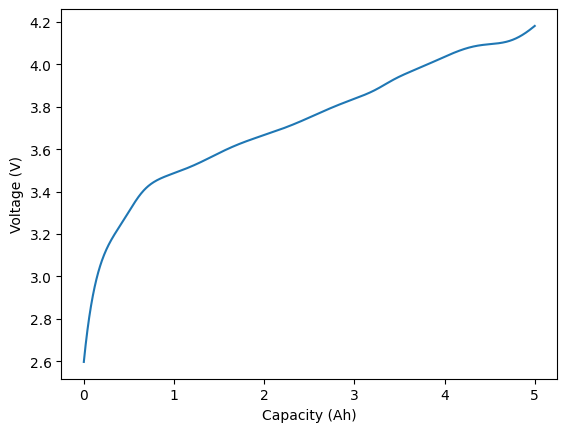

In [4]:
n_pts = 1000
# positive electrode
x_pe_lo = 0.85  # stoichiometry at low cell SOC
x_pe_hi = 0.27  # stoichiometry at high cell SOC
x_pe = np.linspace(x_pe_lo, x_pe_hi, n_pts)  # stoichiometry range

# negative electrode
x_ne_lo = 0.03  # stoichiometry at low cell SOC
x_ne_hi = 0.9  # stoichiometry at high cell SOC
x_ne = np.linspace(x_ne_lo, x_ne_hi, n_pts)  # stoichiometry range

# full cell voltage and capacity
voltage = nmc_LGM50_ocp_Chen2020(x_pe) - graphite_LGM50_ocp_Chen2020(x_ne)
capacity = np.linspace(0, 5, n_pts)  # capacity range in Ah

plt.figure()
plt.plot(capacity, voltage)
plt.xlabel("Capacity (Ah)")
plt.ylabel("Voltage (V)")

We will now generate a fit to this voltage curve.

First, we must create instances of the OCP class to hold our electrode OCP information:

In [5]:
neg_ocp = dma.OCP(graphite_LGM50_ocp_Chen2020)
pos_ocp = dma.OCP(nmc_LGM50_ocp_Chen2020)

In this example, we have directly declared the OCPs since we already have callable functions for them. Alternatively you can use the `from_data` or `from_expression` to define your OCP from data points or a Sympy expression.

Now we can fit to the ocv curve:

In [6]:
# put the voltage and capacity data into a Result object (not necessary in normal use)
OCV_result = pyprobe.Result(
    base_dataframe=pl.DataFrame({"Capacity [Ah]": capacity, "Voltage [V]": voltage}),
    info={},
)

stoichiometry_limits, fitted_curve = dma.run_ocv_curve_fit(
    input_data=OCV_result,
    ocp_ne=neg_ocp,
    ocp_pe=pos_ocp,
    fitting_target="OCV",
    optimizer="minimize",
    optimizer_options={
        "x0": np.array([0.9, 0.1, 0.1, 0.9]),
        "bounds": [(0, 1), (0, 1), (0, 1), (0, 1)],
    },
)

This produces two result objects. The first is the fitted stoichiometry limits:

In [7]:
print(stoichiometry_limits.data)

shape: (1, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ x_pe low   ┆ x_pe high  ┆ x_ne low   ┆ x_ne high ┆ Cell      ┆ Cathode   ┆ Anode     ┆ Li        │
│ SOC        ┆ SOC        ┆ SOC        ┆ SOC       ┆ Capacity  ┆ Capacity  ┆ Capacity  ┆ Inventory │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ [Ah]      ┆ [Ah]      ┆ [Ah]      ┆ [Ah]      │
│ f64        ┆ f64        ┆ f64        ┆ f64       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆           ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.85       ┆ 0.27       ┆ 0.03       ┆ 0.9       ┆ 5.0       ┆ 8.62069   ┆ 5.747127  ┆ 7.5       │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


And the second is a result object containing the fitted OCP curve:

Text(0, 0.5, 'Voltage (V)')

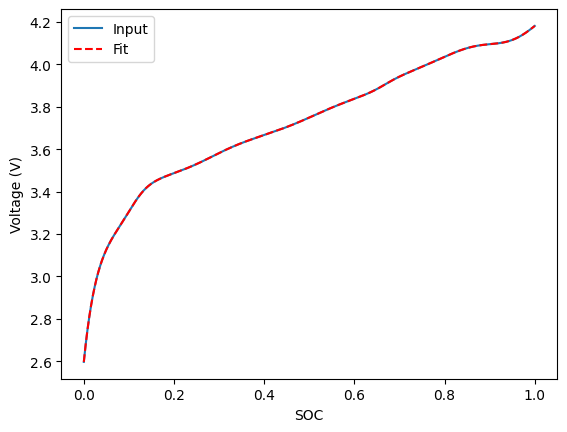

In [8]:
fig, ax = plt.subplots()
fitted_curve.plot(x="SOC", y="Input Voltage [V]", ax=ax, label="Input")
fitted_curve.plot(
    x="SOC", y="Fitted Voltage [V]", ax=ax, color="red", label="Fit", linestyle="--"
)
ax.set_ylabel("Voltage (V)")

You can also fit to differentiated voltage data:

shape: (1, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ x_pe low   ┆ x_pe high  ┆ x_ne low   ┆ x_ne high ┆ Cell      ┆ Cathode   ┆ Anode     ┆ Li        │
│ SOC        ┆ SOC        ┆ SOC        ┆ SOC       ┆ Capacity  ┆ Capacity  ┆ Capacity  ┆ Inventory │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ [Ah]      ┆ [Ah]      ┆ [Ah]      ┆ [Ah]      │
│ f64        ┆ f64        ┆ f64        ┆ f64       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆           ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.849924   ┆ 0.27001    ┆ 0.030006   ┆ 0.90001   ┆ 5.0       ┆ 8.621974  ┆ 5.747105  ┆ 7.500473  │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


Text(0, 0.5, 'dSOCdV (1/V)')

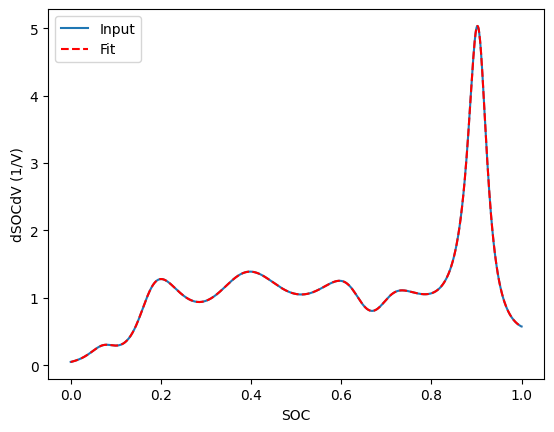

In [9]:
stoichiometry_limits, fitted_curve = dma.run_ocv_curve_fit(
    input_data=OCV_result,
    ocp_ne=neg_ocp,
    ocp_pe=pos_ocp,
    fitting_target="dQdV",
    optimizer="differential_evolution",
    optimizer_options={"bounds": [(0.8, 1), (0.2, 0.3), (0, 0.1), (0.86, 1)]},
)
print(stoichiometry_limits.data)

fig, ax = plt.subplots()
fitted_curve.plot(x="SOC", y="Input dSOCdV [1/V]", ax=ax, label="Input")
fitted_curve.plot(
    x="SOC", y="Fitted dSOCdV [1/V]", ax=ax, color="red", label="Fit", linestyle="--"
)
ax.set_ylabel("dSOCdV (1/V)")

1.  Chen CH, Planella FB, O’Regan K, Gastol D, Widanage WD, Kendrick E. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society. 2020;167(8): 080534. https://doi.org/10.1149/1945-7111/AB9050.